## Self-driving Car Project 5: Vehicle Detection and Tracking

In [152]:
# Import libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
%matplotlib inline
import time

# Libaries for video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Libaries for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import blob_dog, blob_log, blob_doh



## 0. Load data

### Load image directionary

In [3]:
# prepare cars and non-cars image, set file directary
images = glob.glob('/Users/daruizhang/Documents/car_img/*.png')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

### Data summary

In [ ]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Car images:     497
Non-car images: 500
Image size:     (64, 64, 3)
Data type:      float32


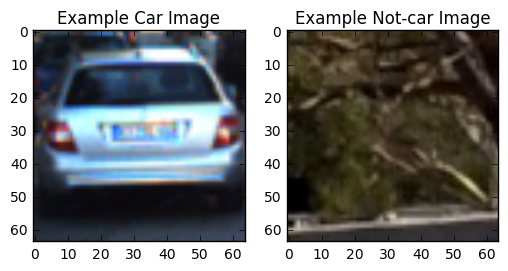

In [93]:
# Basic data summary
data_info = data_look(cars, notcars)
print('Car images:    ', data_info["n_cars"])
print('Non-car images:', data_info["n_notcars"])
print('Image size:    ', data_info["image_shape"])
print('Data type:     ', data_info["data_type"])


# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
noncar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(noncar_image)
plt.title('Example Not-car Image')

## 1. Define Features

### Spatial features

In [79]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    spatial_features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return spatial_features 

Spatial features size: (100,)


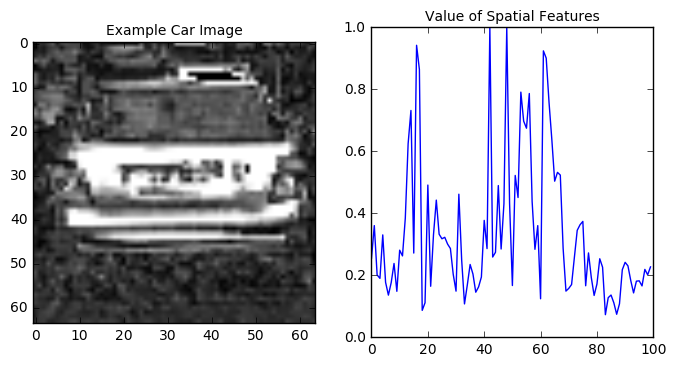

In [120]:
# test if the funtion works
image_hls = cv2.cvtColor(car_image, cv2.COLOR_RGB2HLS) # convert it to HLS
image = image_hls[:,:,2] # work on the satuation channel

# set tuning parameters
spatial = 10

# extract spatial features
spatial_features = bin_spatial(image, size=(spatial, spatial))
print('Spatial features size:', spatial_features.shape)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(image,cmap='gray')
ax1.set_title('Example Car Image', fontsize=10)
ax2.plot(spatial_features)
ax2.set_title('Value of Spatial Features', fontsize=10)


### Color Histogram Features

In [81]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

color hist features size: (96,)


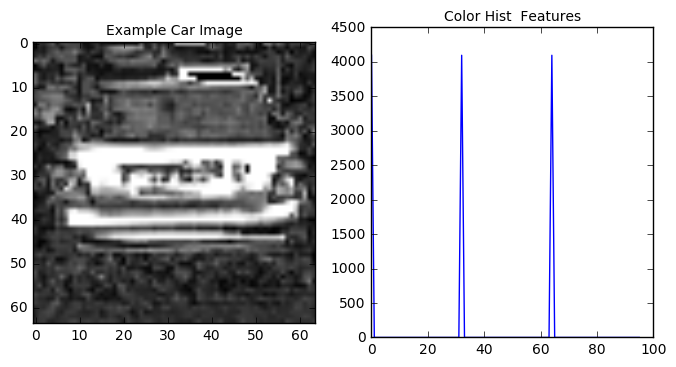

In [117]:
# test if the funtion works
image_hls = cv2.cvtColor(car_image, cv2.COLOR_RGB2HLS) # convert it to HLS
img = image_hls # work on the HSL color space

# set tunning parameter
nbins = 32 #number of bins

# extrect color histo feature
hist_features = color_hist(car_image, nbins, (0, 256))
print('color hist features size:', features.shape)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(image,cmap='gray')
ax1.set_title('Example Car Image', fontsize=10)
ax2.plot(hist_features)
ax2.set_title('Color Hist  Features', fontsize=10)


### HOG feature

In [30]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Hog features shape: (5, 5, 2, 2, 9)
Flatterned Hog features size: (900,)


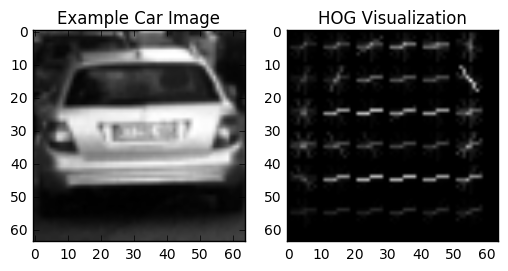

In [135]:
# test if the feature work
gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY) # convert to gray scale
image = gray # work on grey scale image

# Define HOG parameters
orient = 9
pix_per_cell = 10
cell_per_block = 2

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features, hog_image = get_hog_features(image, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# flattern the feature to create the feature vector
hog_1d = np.ravel(hog_features) 

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# test the funtion
print('Hog features shape:', hog_features.shape)
print('Flatterned Hog features size:', hog_1d.shape)

### Extract featuress

In [131]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256),
                     orient = 9,pix_per_cell = 8,cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'  
        HLS_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(HLS_image[:,:,2], size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(HLS_image, nbins=hist_bins, bins_range=hist_range)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = get_hog_features(gray_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
        
    # Return list of feature vectors
    return features

In [137]:
# define tunning parameters
spatial = 10

# color hist parameters
histbin = 32

# Define HOG parameters
orient = 9
pix_per_cell = 10
cell_per_block = 2

# extract feature from car images
car_features = extract_features(cars, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient = orient,pix_per_cell = pix_per_cell,
                        cell_per_block=cell_per_block)

# extract feature noncar car images
notcar_features = extract_features(notcars, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient = orient,pix_per_cell = pix_per_cell,
                        cell_per_block=cell_per_block)

X = np.vstack((car_features, notcar_features)).astype(np.float32)   
print("Number of data:    ",scaled_X.shape[0])
print("Number of features:",scaled_X.shape[1])

Number of data:     997
Number of features: 772


### Feature normalization

In [138]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

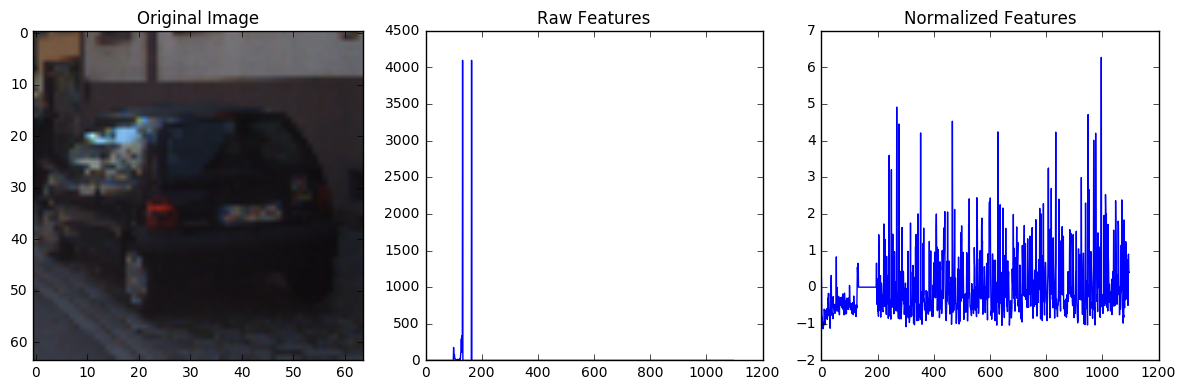

In [140]:
# plot feature normalization
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### split trainign and test set

In [147]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Training set:', X_train.shape[0])
print('Test set    :', X_test.shape[0])


Training set: 797
Test set    : 200


## 2. Define classifier

### Train a classifier

In [148]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


0.05 Seconds to train SVC...


### Test the classifier

In [149]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  1.0
My SVC predicts:  [ 0.  1.  0.  1.  1.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  1.  1.  1.  0.  1.  0.  1.]
0.00228 Seconds to predict 10 labels with SVC


## 3.Define Sliding Window

### Draw boxes

In [150]:
# draw boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

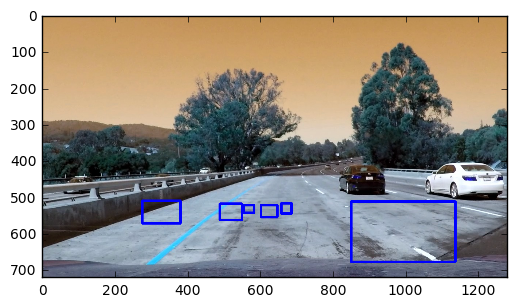

In [151]:
# test if the function works
# Here are the bounding boxes I used
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

# load an image
img1 = cv2.imread('test_images/test1.jpg')
img_box = draw_boxes(img1, bboxes, color=(0, 0, 255), thick=6)
plt.imshow(img_box)

### sliding window

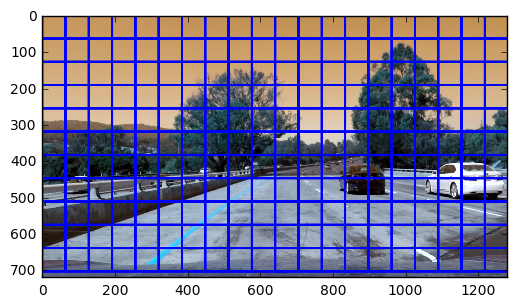

In [90]:
image = img1

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)